### Notes

The Fauseweh-Zhu paper [here](https://arxiv.org/pdf/2112.04276).

Variational Quantum Design Course from IBMQ Learning
- [Ansatz](https://learning.quantum.ibm.com/course/variational-algorithm-design/ansatze-and-variational-forms) include the NLocal, we use TwoLocal (but i already wrote this)
- [Optimisation](https://learning.quantum.ibm.com/course/variational-algorithm-design/optimization-loops) frameworks have also been discussed

- Also check out [Quantum Approximate Optimization Algorithm](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)

## Imports

In [1]:
!python3 --version
!pip freeze | grep qiskit
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal, UGate, PauliEvolutionGate
from qiskit.quantum_info import Statevector, SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction
from scipy.optimize import minimize

Python 3.12.3
qiskit==1.1.0
qiskit-algorithms==0.3.0
qiskit-nature==0.7.2


## Parameters

In [2]:
chain_length = 4

Ω = 2.5

omit_entaglement_ratio = 0

In [3]:
num_layers = 6
periods = 1
num_time_steps = 150
dt = periods / num_time_steps * 2*np.pi/Ω
A = 0

In [4]:
cost_threshold = 1e-3

parameter_space_size = 2 * chain_length + 3 * chain_length * num_layers
param_space = ParameterVector('θ', parameter_space_size)

parameter_space_size2 = (2 * chain_length + 2 * chain_length) * num_layers
param_space2 = ParameterVector('θ', parameter_space_size2)

## Functions

#### Ansatz creator for spin chain

In [5]:
def create_ansatz_circuit(qc, num_layers=num_layers, param_space=param_space):
    param_counter = -1
    def ansatz_circuit_0(qc, param_space, param_counter=0):
        print('Number of params:',parameter_space_size)
        # layer 0
        # param_counter=0
        for i in range(qc.num_qubits):
            qc.rx(param_space[param_counter:=param_counter+1],i)
            qc.rz(param_space[param_counter:=param_counter+1],i)
        return param_counter
    def ansatz_circuit_1(qc, param_space, param_counter=0):
        # param_counter = 2 * chain_length
        for i in range(qc.num_qubits-1):
            qc.cx(i,i+1)
        qc.cx(-1,0)
        for i in range(qc.num_qubits):
            qc.rz(param_space[param_counter:=param_counter+1],i)
            qc.rx(param_space[param_counter:=param_counter+1],i)
            qc.rz(param_space[param_counter:=param_counter+1],i)
        return param_counter
    param_counter = ansatz_circuit_0(qc, param_space, param_counter)
    for i in range(num_layers):
        param_counter = ansatz_circuit_1(qc, param_space, param_counter)
    display(qc.draw('mpl'))

#### Ansatz creator for spin ladder

In [6]:
def ansatz_circuit_ladder(qc, param_space=param_space2, omit_ratio=omit_entaglement_ratio):
    counter = -1
    def layer(qc, params, param_counter):
        for i in range(qc.num_qubits):
            qc.rx(params[param_counter:=param_counter+1],i)
            qc.rz(params[param_counter:=param_counter+1],i)
        return param_counter
    def entangle(qc, params, param_counter, double_entangle):
        for i in range(qc.num_qubits//2):
            qc.rzz(params[param_counter:=param_counter+1], 2*i, 2*i+1)
        if double_entangle:
            for i in range((qc.num_qubits-1)//2):
                qc.rzz(params[param_counter:=param_counter+1], 2*i+1, 2*i+2)
        return param_counter
    fra = Fraction(omit_ratio).limit_denominator()
    # print(fra)
    for layer_count in range(num_layers):
        counter = layer(qc, param_space, counter)
        counter = entangle(qc, param_space, counter, double_entangle= (layer_count%fra.denominator<fra.numerator) )
        qc.barrier()
    display(qc.draw('mpl'))

#### System Definitions

In [7]:
def hamiltonian(t, A=2, J=1, Ω=Ω):
    creator = ['I']*chain_length
    paulis = ['I','X','Y','Z']
    ham = [] # [('X',1.0)]
    for i in range(chain_length-1):
        for j in range(1,4):
            op = creator[:]
            op[i] = paulis[j]
            op[i+1] = paulis[j]
            ham.append([''.join(op), -J/4])
    for i in range(chain_length):
        op1, op2 = creator[:], creator[:]
        op1[i] = 'X'
        op2[i] = 'Y'
        ham.append([''.join(op1), A * np.cos(Ω*t)])
        ham.append([''.join(op2), A * np.sin(Ω*t)])
    ham = np.array(ham)
    # print(A * np.cos(Ω*t))
    return SparsePauliOp(ham[:,0], ham[:,1])

def hamiltonian_linear(t, Δ=1, Ω=Ω):
    ham = SparsePauliOp(['Z','X'] , [-Δ/2, A/2/Ω*np.cos(Ω*t)])
    # plt.plot(t, A*np.cos(Ω*t)/2,'.')
    return ham

def unitary_time_evolution(ham, num_qbits=chain_length, time=num_time_steps*dt, dt=dt):#num_steps=num_time_steps):

    circuit = QuantumCircuit(num_qbits)
    
    for i in range(1, num_time_steps+1):
        circuit.append(PauliEvolutionGate(ham(i*dt), time=dt), range(num_qbits))

    # print('Unitary Evolution Circuit')
    # display(circuit.draw('mpl'))
    
    return circuit

#### Circuit Creation

In [8]:
def overlap(circuit1, circuit2): # < circuit1 | circuit2 >
    circuit_state1 = Statevector.from_instruction(circuit1)
    circuit_state2 = Statevector.from_instruction(circuit2)
    return np.abs(circuit_state1.inner(circuit_state2))**2
    
def cost_function(params, circuit, unitary_time_evolution, computed_circuits=[], λ=5):
    summation = 0
    if computed_circuits != []:
        summation = np.sum( [overlap(i, circuit) for i in computed_circuits] )
    evolved = circuit.compose(unitary_time_evolution)
    cost = overlap(circuit, evolved) - λ * summation
    return cost

#### Recursive optimiser

In [9]:
def optimise(circuit, unitary_time_evolution, computed_circuits=[], params=np.ones(parameter_space_size)):
    cost = cost_function(params, circuit, unitary_time_evolution, computed_circuits)
    if np.abs(cost-1) < cost_threshold:
        return circuit

    ### optimiser returns a circuit here
    optim_step_circuit = minimize(cost_function, params)
    computed_circuits.append(circuit)
    ###

    return optimise(optim_step_circuit, unitary_time_evolution, computed_circuits)

## Main

### Spin chain

In [10]:
print(hamiltonian_linear(0,2))

SparsePauliOp(['Z', 'X'],
              coeffs=[-1.+0.j,  0.+0.j])


Number of params: 80


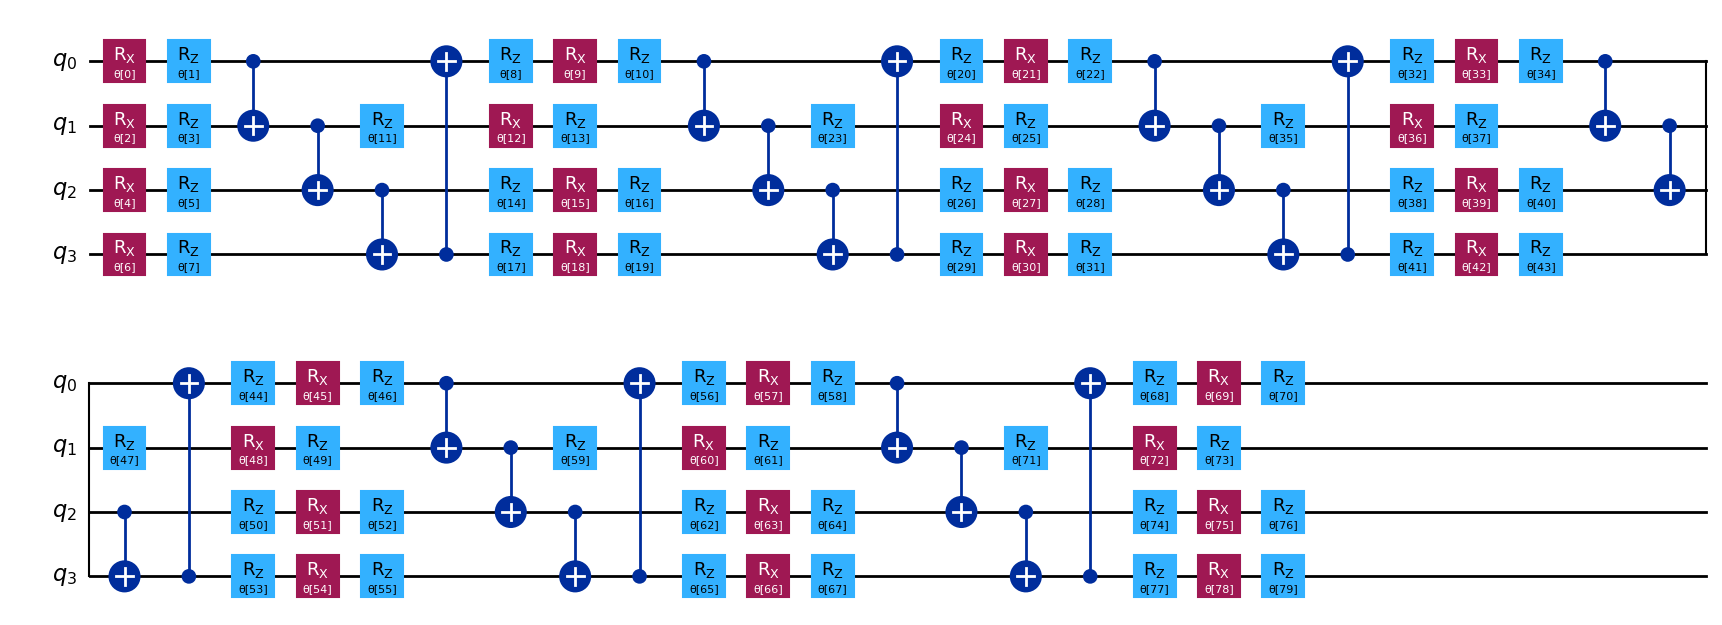

In [11]:
qc = QuantumCircuit(chain_length)

# qc.h(qc.qubits)

create_ansatz_circuit(qc)

unitary = unitary_time_evolution(hamiltonian)

qc.compose(unitary, inplace=True)

# qc.measure_all()

# qc.draw('mpl')

# print(time_evolver(qc, hamiltonian(0)))

#### Linearly Driven

In [12]:
def linear(*initial_guess):
    test_qc = QuantumCircuit(1)
    # params = [Parameter(f'θ[{i}]') for i in range(3)]
    
    test_qc.u(*initial_guess, 0)

    unitary_timevo_circuit = unitary_time_evolution(hamiltonian_linear, 1)

    evolved = test_qc.compose(unitary_timevo_circuit)

    return optimise(test_qc, evolved)

    # display(test_qc.draw('mpl'))

A = 1/Ω

linear(0,0,0)    

Number of params: 80


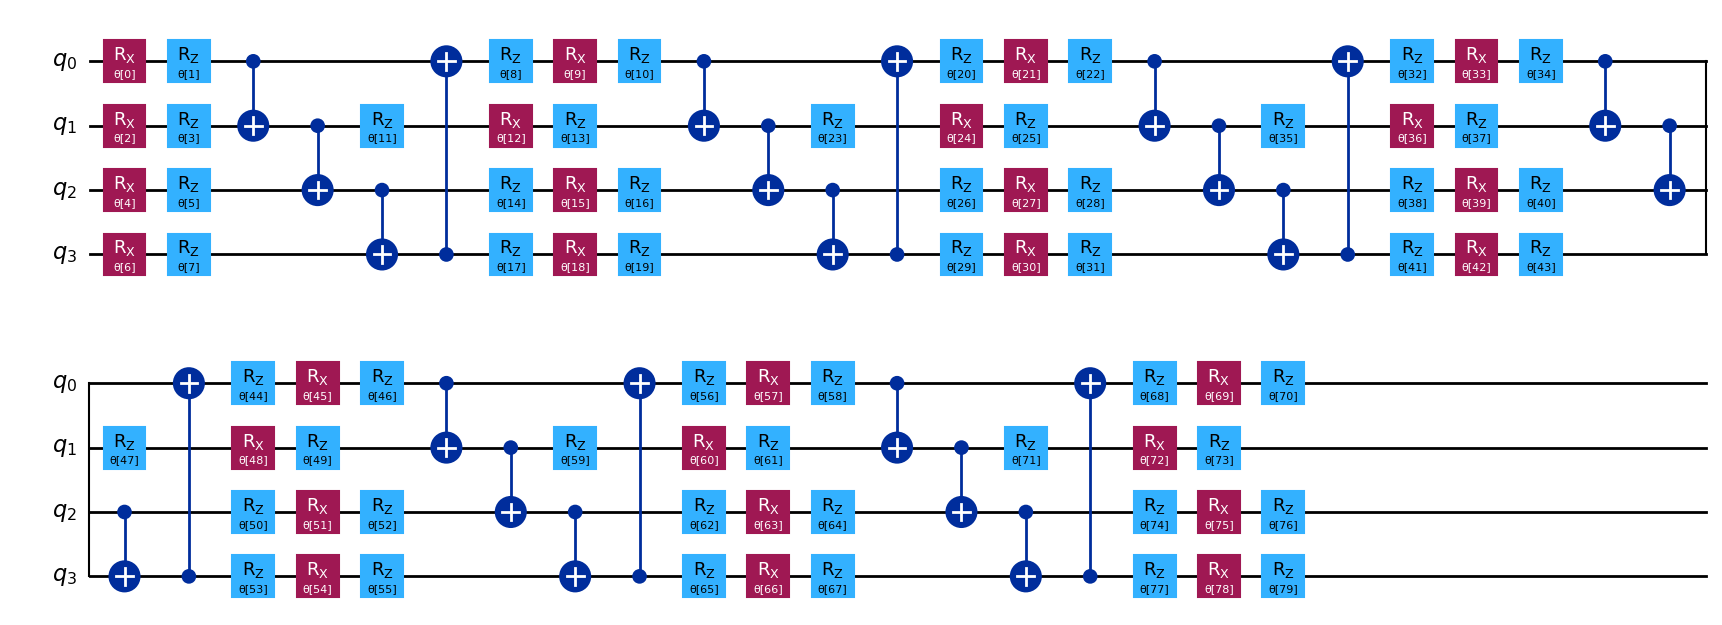

In [13]:
def main():
    test_qc = QuantumCircuit(chain_length)
    # params = [Parameter(f'θ[{i}]') for i in range(3)]

    create_ansatz_circuit(test_qc)

    # display(test_qc.draw('mpl'))

    unitary_timevo_circuit = unitary_time_evolution(hamiltonian)

    evolved = test_qc.compose(unitary_timevo_circuit)

    # print(overlap(test_qc, evolved))

    # display(test_qc.draw('mpl'))

main()    

In [14]:
dt

0.016755160819145565

### Spin ladder

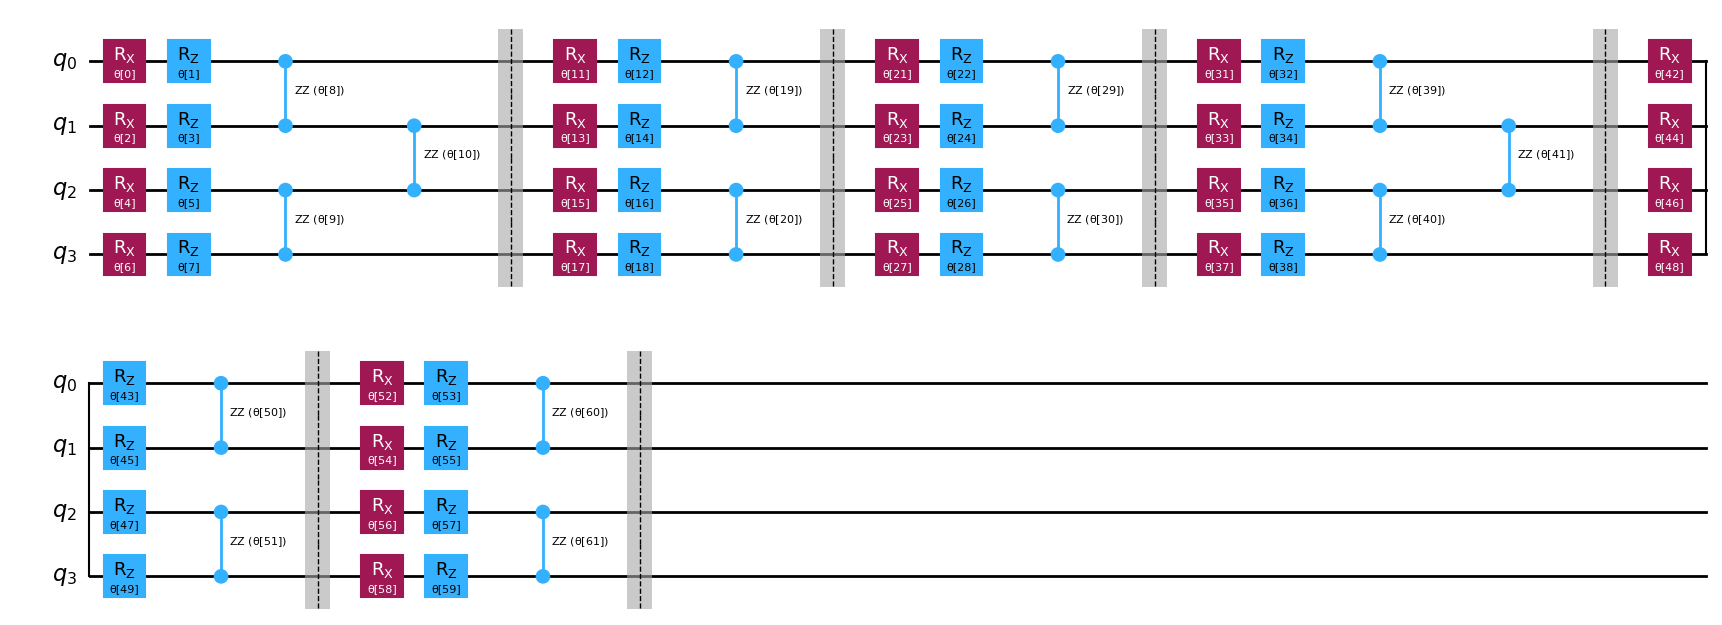

In [15]:
qc = QuantumCircuit(4)

ansatz_circuit_ladder(qc, omit_ratio=1/3)